<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные в порядке

## Анализ

In [6]:
decomposed_data = seasonal_decompose(data)

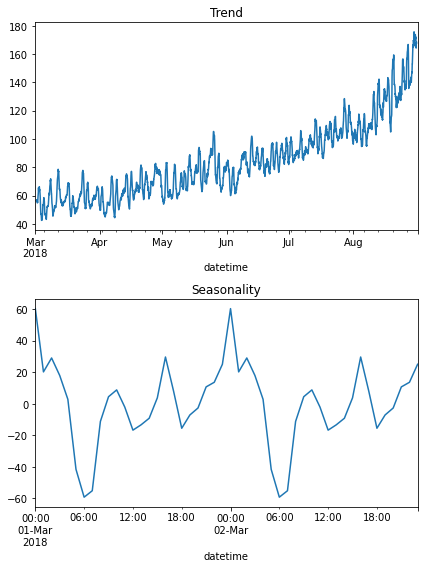

In [7]:
plt.figure(figsize=(6, 8))
plt.subplot(211)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed_data.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.tight_layout()

Имеем восходящий тренд. По графику сезонности видно, что количество клиентов к 12 ночи увеличивается, к 6 утра спадает (по крайней мере на начало марта 2018 года).

In [8]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data


new_data = make_features(data, 20, 20)

In [9]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int64  
 2   day           4416 non-null   int64  
 3   dayofweek     4416 non-null   int64  
 4   hour          4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-null   float64
 17  lag_13        4403 non-null

По сути, задание то же, что и было на последних заданиях тренажера, поэтому я втупую копирую код)

Правда честно говоря, не очень понимаю, какую инфу дают признаки `lag_`

## Обучение

In [10]:
train, test = train_test_split(new_data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [11]:
%%time

tss = TimeSeriesSplit()

MLA = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    LGBMRegressor(),
    KNeighborsRegressor()
]

row_index = 0

# Создаем таблицу для сравнения моделей
MLA_cols = ['Model', 'RMSE', 'Time']
MLA_compare = pd.DataFrame(columns = MLA_cols)

# Добавляем метрики и время в таблицу
for model in MLA:
    MLA_compare.loc[row_index, 'Model'] = model.__class__.__name__   
    tic = time.perf_counter()
    cv_results = cross_val_score(model, X_train, y_train, cv=tss, scoring='neg_root_mean_squared_error', n_jobs=-1)
    toc = time.perf_counter()
    MLA_compare.loc[row_index, 'RMSE'] = cv_results.mean()
    MLA_compare.loc[row_index, 'Time'] = toc - tic
    
    row_index+=1

# Результаты
MLA_compare.sort_values(by=['RMSE'], ascending=False, inplace=True)
MLA_compare

CPU times: total: 156 ms
Wall time: 7.02 s


,Model,RMSE,Time
3,LGBMRegressor,-25.05221,0.357077
2,RandomForestRegressor,-25.147534,3.290077
4,KNeighborsRegressor,-27.509093,0.092596
0,LinearRegression,-30.953286,2.251403
1,DecisionTreeRegressor,-35.717664,1.021374


Градиентный бустинг выдал лучший результат. Подберем для него параметры

In [1]:
# from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

# def objective(search_space):
#     model = LGBMRegressor(**search_space, random_state=42)
#     rmse = cross_val_score(model, X_train, y_train, cv=tss, scoring='neg_root_mean_squared_error').mean()
#     return {'loss': -rmse, 'status': STATUS_OK}

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
# max_depth = [int(x) for x in np.linspace(5, 30, num = 10)]
# num_leaves = [int(x) for x in np.linspace(50, 200, num=20)]

# search_space = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'num_leaves': num_leaves,
# }

# algorithm=tpe.suggest  # использовать Tree of Parzen Estimators

# best_params = fmin(
#   fn=objective,
#   space=search_space,
#   algo=algorithm,
#   max_evals=10
# )

# space_eval(search_space, best_params)

In [12]:
# %%time

# lgbm = LGBMRegressor()

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
# max_depth = [int(x) for x in np.linspace(5, 30, num = 10)]
# num_leaves = [int(x) for x in np.linspace(50, 200, num=20)]


# param_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'num_leaves': num_leaves,
# }

# rf_random = RandomizedSearchCV(estimator = lgbm, 
#                                param_distributions = param_grid, 
#                                n_iter = 30,
#                                cv = tss, 
#                                verbose=2, 
#                                random_state=42,
#                                scoring='neg_root_mean_squared_error',
#                                n_jobs = -1)

# rf_random.fit(X_train, y_train)
# print(rf_random.best_score_)
# print(rf_random.best_params_)

LGDM показал rmse = 25.09 со следующими параметрами: {'num_leaves': 97, 'n_estimators': 242, 'max_depth': 7}

Дефолтные значения были лучше. Переберем еще пару моделей

In [13]:
# %%time

# knr = KNeighborsRegressor()

# n_neighbours = [int(x) for x in np.linspace(start = 5, stop = 15, num = 10)]

# param_grid = {
#     'n_neighbors': n_neighbours,
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree']
# }

# rf_random = RandomizedSearchCV(estimator = knr, 
#                                param_distributions = param_grid, 
#                                n_iter = 50,
#                                cv = tss, 
#                                verbose=2, 
#                                random_state=42,
#                                scoring='neg_root_mean_squared_error',
#                                n_jobs = -1)

# rf_random.fit(X_train, y_train)
# print(rf_random.best_score_)
# print(rf_random.best_params_)

Соседи показали rmse = 27.32 со следующими параметрами: {'weights': 'distance', 'n_neighbors': 6, 'algorithm': 'auto'}

In [14]:
# %%time

# forest = RandomForestRegressor()


# random_grid = {'bootstrap': [True, False],
#                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
#                'max_features': ['auto', 'sqrt'],
#                'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
#                'n_estimators': [130, 180, 230]
#               }

# rf_random = RandomizedSearchCV(estimator = forest, 
#                                param_distributions = random_grid, 
#                                n_iter = 20,
#                                cv = tss, 
#                                verbose=2, 
#                                random_state=42,
#                                scoring='neg_root_mean_squared_error',
#                                n_jobs = -1)

# rf_random.fit(X_train, y_train)
# print(rf_random.best_score_)
# print(rf_random.best_params_)

Лес показал rmse = 25.10 со следующими параметрами: {'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}

In [15]:
# cat = CatBoostRegressor()
# grid = {'depth'         : [4,5,6,7,8,9, 10],
#        'learning_rate' : [0.01,0.02,0.03,0.04],
#        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
#                 }

# grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, verbose=False, plot=True)

In [16]:
# grid_search_result['params']

CatBoost показал rmse = 24.74 со следующими параметрами: {'depth': 7, 'iterations': 100, 'learning_rate': 0.04}

## Тестирование

In [17]:
%%time


MLA = [
    LinearRegression(),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(n_estimators=180, 
                          min_samples_split=5, 
                          min_samples_leaf=1, 
                          max_features='auto', 
                          max_depth=60, 
                          bootstrap=True),
    LGBMRegressor(num_leaves=97, n_estimators=242, max_depth=7),
    KNeighborsRegressor(weights='distance', n_neighbors=6, algorithm='auto'),
    CatBoostRegressor(depth=7, learning_rate=0.04, iterations=100)
]

row_index = 0

# Создаем таблицу для сравнения моделей
MLA_cols = ['Model', 'RMSE']
MLA_compare = pd.DataFrame(columns = MLA_cols)

# Добавляем метрики и время в таблицу
for model in MLA:
    MLA_compare.loc[row_index, 'Model'] = model.__class__.__name__      
    predictions = model.fit(X_train, y_train).predict(X_test)
    MLA_compare.loc[row_index, 'RMSE'] = mean_squared_error(y_test, predictions, squared=False)
    
    row_index+=1

# Результаты
MLA_compare.sort_values(by=['RMSE'], ascending=True, inplace=True)
MLA_compare

0:	learn: 37.9803404	total: 55.1ms	remaining: 5.45s
1:	learn: 37.2185733	total: 59.2ms	remaining: 2.9s
2:	learn: 36.6563635	total: 63.2ms	remaining: 2.04s
3:	learn: 36.0033277	total: 67.6ms	remaining: 1.62s
4:	learn: 35.5107701	total: 71.6ms	remaining: 1.36s
5:	learn: 34.9521949	total: 75.6ms	remaining: 1.18s
6:	learn: 34.3690965	total: 79.9ms	remaining: 1.06s
7:	learn: 33.8385103	total: 84.3ms	remaining: 970ms
8:	learn: 33.3726406	total: 88.4ms	remaining: 894ms
9:	learn: 32.9315206	total: 92.3ms	remaining: 831ms
10:	learn: 32.4735790	total: 96.3ms	remaining: 780ms
11:	learn: 32.0161705	total: 101ms	remaining: 738ms
12:	learn: 31.5538481	total: 104ms	remaining: 699ms
13:	learn: 31.1403901	total: 108ms	remaining: 665ms
14:	learn: 30.7422919	total: 112ms	remaining: 636ms
15:	learn: 30.3337014	total: 116ms	remaining: 611ms
16:	learn: 29.9660601	total: 120ms	remaining: 588ms
17:	learn: 29.6050585	total: 124ms	remaining: 567ms
18:	learn: 29.3098906	total: 128ms	remaining: 547ms
19:	learn: 2

,Model,RMSE
3,LGBMRegressor,42.457103
2,RandomForestRegressor,44.408141
4,KNeighborsRegressor,51.19599
5,CatBoostRegressor,52.30963
0,LinearRegression,54.436286
1,DecisionTreeRegressor,56.606558


Видим, что модель переобучилась, поскольку на трейне lgbm выдавал rmse=25, а на тесте - 42.45. Однако по заданию мы проходим.

Удостоверимся, что сделали хоть что-то полезное через модель, состоящую из медиан

In [18]:
pred_median = pd.Series(y_train.median(), index=test.index)
print("RMSE:", mean_squared_error(y_test, pred_median, squared=False))

RMSE: 87.15277582981295


Слава богу

Лучше всего себя показала модель градиентного бустинга с результатом RMSE = 42.45 со следующими параметрами: num_leaves=97, n_estimators=242, max_depth=7. 

Результат не идеальный, тк модель переобучается, возможно имеет смысл избавиться от лишних созданных признаков. Визувлизируем предсказания

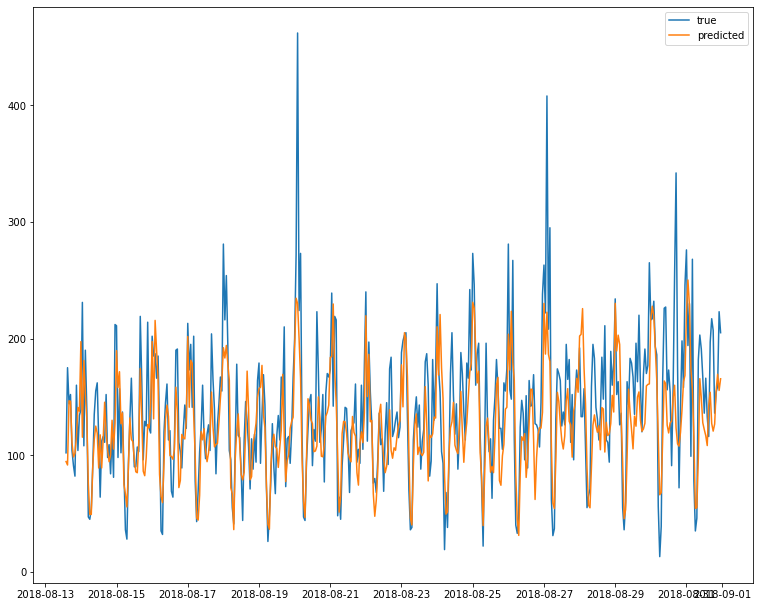

In [19]:
lgbm = LGBMRegressor(num_leaves=97, n_estimators=242, max_depth=7)
predictions = lgbm.fit(X_train, y_train).predict(X_test)

pred = pd.Series(predictions, index=y_test.index)

fig = plt.figure(figsize=(10,8))

ax = fig.add_axes([0,0,1,1])

ax.plot(y_test, label='true')
ax.plot(pred, label='predicted')
        
ax.legend();
plt.tight_layout()

Как видно, модель плохо улавливает выбросы, а они нам и нужны